In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import rasterio
import numpy as np
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, random_split
from torchgeo.transforms import indices
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning) # biomassters rasters are not georeferenced
warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

In [3]:
%cd ../
import src.data_geo.transforms as tf
import src.data_geo.dataloading as dl

/home/broug/Desktop/DD-Finland-Forests


In [4]:
# MPS Docs
# https://pytorch.org/docs/master/notes/mps.html

if torch.backends.mps.is_available(): # Mac M1/M2
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

loader_device = torch.device('cpu')  # found that using cpu for data loading was faster than gpu (for my device)
print(f'training device: {device}')
print(f'loader_device: {loader_device}')

training device: cuda
loader_device: cpu


In [5]:
PATH = '~/Desktop/DD-Finland-Forests'
dir_tiles = 'data/train/train_features'
dir_target = 'data/train/train_agbm'
dir_saved_models = './trained_models'
metadata = 'data/features_metadata.csv'

In [6]:
# Map of tensor channels *after* transforms, not accounting for bands dropped by the DropBands transform
# Useful for choosing which bands to keep 
band_map = {  
    # S2 bands
    0: 'S2-B2: Blue-10m',
    1: 'S2-B3: Green-10m',
    2: 'S2-B4: Red-10m',
    3: 'S2-B5: VegRed-704nm-20m',
    4: 'S2-B6: VegRed-740nm-20m',
    5: 'S2-B7: VegRed-780nm-20m',
    6: 'S2-B8: NIR-833nm-10m',
    7: 'S2-B8A: NarrowNIR-864nm-20m',
    8: 'S2-B11: SWIR-1610nm-20m',
    9: 'S2-B12: SWIR-2200nm-20m',
    10: 'S2-CLP: CloudProb-160m',
    # S1 bands
    11: 'S1-VV-Asc: Cband-10m',
    12: 'S1-VH-Asc: Cband-10m',
    13: 'S1-VV-Desc: Cband-10m',
    14: 'S1-VH-Desc: Cband-10m',
    # Bands derived by transforms 
    15: 'S2-NDVI: (NIR-Red)/(NIR+Red) 10m',
    16: 'S1-NDVVVH-Asc: Norm Diff VV & VH, 10m',
    17: 'S2-NDBI: Difference Built-up Index, 20m',
    18: 'S2-NDRE: Red Edge Vegetation Index, 20m',
    19: 'S2-NDSI: Snow Index, 20m',
    20: 'S2-NDWI: Water Index, 10m',
    21: 'S2-SWI: Sandardized Water-Level Index, 20m',
    22: 'S1-VV/VH-Asc: Cband-10m',
    23: 'S2-VV/VH-Desc: Cband-10m'
}
month_map = {
    0: 'Sep', 1: 'Oct', 2: 'Nov', 3: 'Dec',
    4: 'Jan', 5: 'Feb', 6: 'Mar', 7: 'Apr',
    8: 'May', 9: 'Jun', 10: 'Jul', 11: 'Aug'
}

In [7]:
bands_to_keep = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21] # via offline feature selection  

transforms = nn.Sequential(
    tf.ClampAGBM(vmin=0., vmax=500.),                # exclude AGBM outliers, 500 is good upper limit per AGBM histograms 
    indices.AppendNDVI(index_nir=6, index_red=2),    # NDVI, index 15
    indices.AppendNormalizedDifferenceIndex(index_a=11, index_b=12), # (VV-VH)/(VV+VH), index 16
    indices.AppendNDBI(index_swir=8, index_nir=6),   # Difference Built-up Index for development detection, index 17
    indices.AppendNDRE(index_nir=6, index_vre1=3),   # Red Edge Vegetation Index for canopy detection, index 18
    indices.AppendNDSI(index_green=1, index_swir=8), # Snow Index, index 19
    indices.AppendNDWI(index_green=1, index_nir=6),  # Difference Water Index for water detection, index 20 
    indices.AppendSWI(index_vre1=3, index_swir2=8),  # Standardized Water-Level Index for water detection, index 21
    tf.AppendRatioAB(index_a=11, index_b=12),        # VV/VH Ascending, index 22
    tf.AppendRatioAB(index_a=13, index_b=14),        # VV/VH Descending, index 23
    tf.DropBands(loader_device, bands_to_keep)       # DROPS ALL BUT SPECIFIED bands_to_keep
)

In [8]:
# this file specifies which month of data to use for training for each chipid 
# See the preprocesing notebook for an example of producing this  
tile_file = './TILE_LIST_BEST_MONTHS.csv'

max_chips = None # number of chips to use from training set, None = Use All  

# A custom dataloader for Sentinel data 
dataset = dl.SentinelDataset(tile_file=tile_file, 
                             dir_tiles=dir_tiles, 
                             dir_target=dir_target,
                             max_chips=max_chips,
                             transform=transforms,
                             device=loader_device,
                             metadata=metadata,
                             path=PATH
                            )

torch.manual_seed(0)

train_frac = 0.8
upper = int(len(dataset)*train_frac)
lower = len(dataset) - upper
train_dataset, val_dataset = random_split(dataset, [upper, lower])
print(f'N training samples: {len(train_dataset)}')

N training samples: 6951


In [9]:
batch_size = 32  # Note: training speed is sensitive to memory usage
                 # set this as high as you can without significantly slowing down training time 
num_workers = 8
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=True
                             )
val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=num_workers,
                            pin_memory=True
                           )

In [18]:
in_channels = train_dataset[0]['image'].shape[0]
print(f'# input channels: {in_channels}')

model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None, # 'imagenet' weights don't seem to help so start clean 
    in_channels=in_channels,                 
    classes=1,                     
).to(device)

# input channels: 20


In [16]:
#  model.load_state_dict(torch.load(f'trained_models/resnet50-sentinel2.pt'))
# # model.train()

RuntimeError: Error(s) in loading state_dict for Unet:
	Missing key(s) in state_dict: "encoder.conv1.weight", "encoder.bn1.weight", "encoder.bn1.bias", "encoder.bn1.running_mean", "encoder.bn1.running_var", "encoder.layer1.0.conv1.weight", "encoder.layer1.0.bn1.weight", "encoder.layer1.0.bn1.bias", "encoder.layer1.0.bn1.running_mean", "encoder.layer1.0.bn1.running_var", "encoder.layer1.0.conv2.weight", "encoder.layer1.0.bn2.weight", "encoder.layer1.0.bn2.bias", "encoder.layer1.0.bn2.running_mean", "encoder.layer1.0.bn2.running_var", "encoder.layer1.0.conv3.weight", "encoder.layer1.0.bn3.weight", "encoder.layer1.0.bn3.bias", "encoder.layer1.0.bn3.running_mean", "encoder.layer1.0.bn3.running_var", "encoder.layer1.0.downsample.0.weight", "encoder.layer1.0.downsample.1.weight", "encoder.layer1.0.downsample.1.bias", "encoder.layer1.0.downsample.1.running_mean", "encoder.layer1.0.downsample.1.running_var", "encoder.layer1.1.conv1.weight", "encoder.layer1.1.bn1.weight", "encoder.layer1.1.bn1.bias", "encoder.layer1.1.bn1.running_mean", "encoder.layer1.1.bn1.running_var", "encoder.layer1.1.conv2.weight", "encoder.layer1.1.bn2.weight", "encoder.layer1.1.bn2.bias", "encoder.layer1.1.bn2.running_mean", "encoder.layer1.1.bn2.running_var", "encoder.layer1.1.conv3.weight", "encoder.layer1.1.bn3.weight", "encoder.layer1.1.bn3.bias", "encoder.layer1.1.bn3.running_mean", "encoder.layer1.1.bn3.running_var", "encoder.layer1.2.conv1.weight", "encoder.layer1.2.bn1.weight", "encoder.layer1.2.bn1.bias", "encoder.layer1.2.bn1.running_mean", "encoder.layer1.2.bn1.running_var", "encoder.layer1.2.conv2.weight", "encoder.layer1.2.bn2.weight", "encoder.layer1.2.bn2.bias", "encoder.layer1.2.bn2.running_mean", "encoder.layer1.2.bn2.running_var", "encoder.layer1.2.conv3.weight", "encoder.layer1.2.bn3.weight", "encoder.layer1.2.bn3.bias", "encoder.layer1.2.bn3.running_mean", "encoder.layer1.2.bn3.running_var", "encoder.layer2.0.conv1.weight", "encoder.layer2.0.bn1.weight", "encoder.layer2.0.bn1.bias", "encoder.layer2.0.bn1.running_mean", "encoder.layer2.0.bn1.running_var", "encoder.layer2.0.conv2.weight", "encoder.layer2.0.bn2.weight", "encoder.layer2.0.bn2.bias", "encoder.layer2.0.bn2.running_mean", "encoder.layer2.0.bn2.running_var", "encoder.layer2.0.conv3.weight", "encoder.layer2.0.bn3.weight", "encoder.layer2.0.bn3.bias", "encoder.layer2.0.bn3.running_mean", "encoder.layer2.0.bn3.running_var", "encoder.layer2.0.downsample.0.weight", "encoder.layer2.0.downsample.1.weight", "encoder.layer2.0.downsample.1.bias", "encoder.layer2.0.downsample.1.running_mean", "encoder.layer2.0.downsample.1.running_var", "encoder.layer2.1.conv1.weight", "encoder.layer2.1.bn1.weight", "encoder.layer2.1.bn1.bias", "encoder.layer2.1.bn1.running_mean", "encoder.layer2.1.bn1.running_var", "encoder.layer2.1.conv2.weight", "encoder.layer2.1.bn2.weight", "encoder.layer2.1.bn2.bias", "encoder.layer2.1.bn2.running_mean", "encoder.layer2.1.bn2.running_var", "encoder.layer2.1.conv3.weight", "encoder.layer2.1.bn3.weight", "encoder.layer2.1.bn3.bias", "encoder.layer2.1.bn3.running_mean", "encoder.layer2.1.bn3.running_var", "encoder.layer2.2.conv1.weight", "encoder.layer2.2.bn1.weight", "encoder.layer2.2.bn1.bias", "encoder.layer2.2.bn1.running_mean", "encoder.layer2.2.bn1.running_var", "encoder.layer2.2.conv2.weight", "encoder.layer2.2.bn2.weight", "encoder.layer2.2.bn2.bias", "encoder.layer2.2.bn2.running_mean", "encoder.layer2.2.bn2.running_var", "encoder.layer2.2.conv3.weight", "encoder.layer2.2.bn3.weight", "encoder.layer2.2.bn3.bias", "encoder.layer2.2.bn3.running_mean", "encoder.layer2.2.bn3.running_var", "encoder.layer2.3.conv1.weight", "encoder.layer2.3.bn1.weight", "encoder.layer2.3.bn1.bias", "encoder.layer2.3.bn1.running_mean", "encoder.layer2.3.bn1.running_var", "encoder.layer2.3.conv2.weight", "encoder.layer2.3.bn2.weight", "encoder.layer2.3.bn2.bias", "encoder.layer2.3.bn2.running_mean", "encoder.layer2.3.bn2.running_var", "encoder.layer2.3.conv3.weight", "encoder.layer2.3.bn3.weight", "encoder.layer2.3.bn3.bias", "encoder.layer2.3.bn3.running_mean", "encoder.layer2.3.bn3.running_var", "encoder.layer3.0.conv1.weight", "encoder.layer3.0.bn1.weight", "encoder.layer3.0.bn1.bias", "encoder.layer3.0.bn1.running_mean", "encoder.layer3.0.bn1.running_var", "encoder.layer3.0.conv2.weight", "encoder.layer3.0.bn2.weight", "encoder.layer3.0.bn2.bias", "encoder.layer3.0.bn2.running_mean", "encoder.layer3.0.bn2.running_var", "encoder.layer3.0.conv3.weight", "encoder.layer3.0.bn3.weight", "encoder.layer3.0.bn3.bias", "encoder.layer3.0.bn3.running_mean", "encoder.layer3.0.bn3.running_var", "encoder.layer3.0.downsample.0.weight", "encoder.layer3.0.downsample.1.weight", "encoder.layer3.0.downsample.1.bias", "encoder.layer3.0.downsample.1.running_mean", "encoder.layer3.0.downsample.1.running_var", "encoder.layer3.1.conv1.weight", "encoder.layer3.1.bn1.weight", "encoder.layer3.1.bn1.bias", "encoder.layer3.1.bn1.running_mean", "encoder.layer3.1.bn1.running_var", "encoder.layer3.1.conv2.weight", "encoder.layer3.1.bn2.weight", "encoder.layer3.1.bn2.bias", "encoder.layer3.1.bn2.running_mean", "encoder.layer3.1.bn2.running_var", "encoder.layer3.1.conv3.weight", "encoder.layer3.1.bn3.weight", "encoder.layer3.1.bn3.bias", "encoder.layer3.1.bn3.running_mean", "encoder.layer3.1.bn3.running_var", "encoder.layer3.2.conv1.weight", "encoder.layer3.2.bn1.weight", "encoder.layer3.2.bn1.bias", "encoder.layer3.2.bn1.running_mean", "encoder.layer3.2.bn1.running_var", "encoder.layer3.2.conv2.weight", "encoder.layer3.2.bn2.weight", "encoder.layer3.2.bn2.bias", "encoder.layer3.2.bn2.running_mean", "encoder.layer3.2.bn2.running_var", "encoder.layer3.2.conv3.weight", "encoder.layer3.2.bn3.weight", "encoder.layer3.2.bn3.bias", "encoder.layer3.2.bn3.running_mean", "encoder.layer3.2.bn3.running_var", "encoder.layer3.3.conv1.weight", "encoder.layer3.3.bn1.weight", "encoder.layer3.3.bn1.bias", "encoder.layer3.3.bn1.running_mean", "encoder.layer3.3.bn1.running_var", "encoder.layer3.3.conv2.weight", "encoder.layer3.3.bn2.weight", "encoder.layer3.3.bn2.bias", "encoder.layer3.3.bn2.running_mean", "encoder.layer3.3.bn2.running_var", "encoder.layer3.3.conv3.weight", "encoder.layer3.3.bn3.weight", "encoder.layer3.3.bn3.bias", "encoder.layer3.3.bn3.running_mean", "encoder.layer3.3.bn3.running_var", "encoder.layer3.4.conv1.weight", "encoder.layer3.4.bn1.weight", "encoder.layer3.4.bn1.bias", "encoder.layer3.4.bn1.running_mean", "encoder.layer3.4.bn1.running_var", "encoder.layer3.4.conv2.weight", "encoder.layer3.4.bn2.weight", "encoder.layer3.4.bn2.bias", "encoder.layer3.4.bn2.running_mean", "encoder.layer3.4.bn2.running_var", "encoder.layer3.4.conv3.weight", "encoder.layer3.4.bn3.weight", "encoder.layer3.4.bn3.bias", "encoder.layer3.4.bn3.running_mean", "encoder.layer3.4.bn3.running_var", "encoder.layer3.5.conv1.weight", "encoder.layer3.5.bn1.weight", "encoder.layer3.5.bn1.bias", "encoder.layer3.5.bn1.running_mean", "encoder.layer3.5.bn1.running_var", "encoder.layer3.5.conv2.weight", "encoder.layer3.5.bn2.weight", "encoder.layer3.5.bn2.bias", "encoder.layer3.5.bn2.running_mean", "encoder.layer3.5.bn2.running_var", "encoder.layer3.5.conv3.weight", "encoder.layer3.5.bn3.weight", "encoder.layer3.5.bn3.bias", "encoder.layer3.5.bn3.running_mean", "encoder.layer3.5.bn3.running_var", "encoder.layer4.0.conv1.weight", "encoder.layer4.0.bn1.weight", "encoder.layer4.0.bn1.bias", "encoder.layer4.0.bn1.running_mean", "encoder.layer4.0.bn1.running_var", "encoder.layer4.0.conv2.weight", "encoder.layer4.0.bn2.weight", "encoder.layer4.0.bn2.bias", "encoder.layer4.0.bn2.running_mean", "encoder.layer4.0.bn2.running_var", "encoder.layer4.0.conv3.weight", "encoder.layer4.0.bn3.weight", "encoder.layer4.0.bn3.bias", "encoder.layer4.0.bn3.running_mean", "encoder.layer4.0.bn3.running_var", "encoder.layer4.0.downsample.0.weight", "encoder.layer4.0.downsample.1.weight", "encoder.layer4.0.downsample.1.bias", "encoder.layer4.0.downsample.1.running_mean", "encoder.layer4.0.downsample.1.running_var", "encoder.layer4.1.conv1.weight", "encoder.layer4.1.bn1.weight", "encoder.layer4.1.bn1.bias", "encoder.layer4.1.bn1.running_mean", "encoder.layer4.1.bn1.running_var", "encoder.layer4.1.conv2.weight", "encoder.layer4.1.bn2.weight", "encoder.layer4.1.bn2.bias", "encoder.layer4.1.bn2.running_mean", "encoder.layer4.1.bn2.running_var", "encoder.layer4.1.conv3.weight", "encoder.layer4.1.bn3.weight", "encoder.layer4.1.bn3.bias", "encoder.layer4.1.bn3.running_mean", "encoder.layer4.1.bn3.running_var", "encoder.layer4.2.conv1.weight", "encoder.layer4.2.bn1.weight", "encoder.layer4.2.bn1.bias", "encoder.layer4.2.bn1.running_mean", "encoder.layer4.2.bn1.running_var", "encoder.layer4.2.conv2.weight", "encoder.layer4.2.bn2.weight", "encoder.layer4.2.bn2.bias", "encoder.layer4.2.bn2.running_mean", "encoder.layer4.2.bn2.running_var", "encoder.layer4.2.conv3.weight", "encoder.layer4.2.bn3.weight", "encoder.layer4.2.bn3.bias", "encoder.layer4.2.bn3.running_mean", "encoder.layer4.2.bn3.running_var", "decoder.blocks.0.conv1.0.weight", "decoder.blocks.0.conv1.1.weight", "decoder.blocks.0.conv1.1.bias", "decoder.blocks.0.conv1.1.running_mean", "decoder.blocks.0.conv1.1.running_var", "decoder.blocks.0.conv2.0.weight", "decoder.blocks.0.conv2.1.weight", "decoder.blocks.0.conv2.1.bias", "decoder.blocks.0.conv2.1.running_mean", "decoder.blocks.0.conv2.1.running_var", "decoder.blocks.1.conv1.0.weight", "decoder.blocks.1.conv1.1.weight", "decoder.blocks.1.conv1.1.bias", "decoder.blocks.1.conv1.1.running_mean", "decoder.blocks.1.conv1.1.running_var", "decoder.blocks.1.conv2.0.weight", "decoder.blocks.1.conv2.1.weight", "decoder.blocks.1.conv2.1.bias", "decoder.blocks.1.conv2.1.running_mean", "decoder.blocks.1.conv2.1.running_var", "decoder.blocks.2.conv1.0.weight", "decoder.blocks.2.conv1.1.weight", "decoder.blocks.2.conv1.1.bias", "decoder.blocks.2.conv1.1.running_mean", "decoder.blocks.2.conv1.1.running_var", "decoder.blocks.2.conv2.0.weight", "decoder.blocks.2.conv2.1.weight", "decoder.blocks.2.conv2.1.bias", "decoder.blocks.2.conv2.1.running_mean", "decoder.blocks.2.conv2.1.running_var", "decoder.blocks.3.conv1.0.weight", "decoder.blocks.3.conv1.1.weight", "decoder.blocks.3.conv1.1.bias", "decoder.blocks.3.conv1.1.running_mean", "decoder.blocks.3.conv1.1.running_var", "decoder.blocks.3.conv2.0.weight", "decoder.blocks.3.conv2.1.weight", "decoder.blocks.3.conv2.1.bias", "decoder.blocks.3.conv2.1.running_mean", "decoder.blocks.3.conv2.1.running_var", "decoder.blocks.4.conv1.0.weight", "decoder.blocks.4.conv1.1.weight", "decoder.blocks.4.conv1.1.bias", "decoder.blocks.4.conv1.1.running_mean", "decoder.blocks.4.conv1.1.running_var", "decoder.blocks.4.conv2.0.weight", "decoder.blocks.4.conv2.1.weight", "decoder.blocks.4.conv2.1.bias", "decoder.blocks.4.conv2.1.running_mean", "decoder.blocks.4.conv2.1.running_var", "segmentation_head.0.weight", "segmentation_head.0.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.bn3.num_batches_tracked", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.0.downsample.1.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.bn3.num_batches_tracked", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.bn3.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.bn3.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.bn3.num_batches_tracked", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.bn3.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.bn3.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.bn3.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.bn3.num_batches_tracked", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.bn3.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.bn3.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.bn3.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.bn3.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.bn3.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.bn3.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.bn3.num_batches_tracked", "fc.weight", "fc.bias". 

In [19]:
loss_module = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [24]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_metrics = []
    
    print('Training')
    for ix, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch['image'].to(device)
        y = batch['label'].to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_metrics.append(np.round(np.sqrt(loss.item()), 5))
            
    return train_metrics


def valid_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    valid_loss = 0
    valid_metrics = {}

    print('Validation')
    with torch.no_grad():
        for batch in tqdm(dataloader, total=num_batches):
            X = batch['image'].to(device)
            y = batch['label'].to(device)
            
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()
            
    valid_loss /= num_batches
    valid_rmse = np.round(np.sqrt(valid_loss), 5)
    print(f"Validation Error: \n RMSE: {valid_rmse:>8f} \n")
    return valid_rmse

In [25]:
def run_training(model, loss_module, optimizer, train_dataloader, val_dataloader, save_path, n_epochs=10):
    min_valid_metric = np.inf
    train_metrics = []
    valid_metrics = []

    for ix in range(n_epochs):
        print(f"\n-------------------------------\nEpoch {ix+1}")
        train_metrics_epoch = train_loop(train_dataloader, model, loss_module, optimizer)
        train_metrics.extend(train_metrics_epoch)
        
        valid_metrics_epoch = valid_loop(val_dataloader, model, loss_module)
        valid_metrics.append((len(train_metrics), valid_metrics_epoch))

        # check validation score, if improved then save model
        if min_valid_metric > valid_metrics_epoch:
            print(f'Validation RMSE Decreased({min_valid_metric:.6f}--->{valid_metrics_epoch:.6f}) \t Saving The Model')
            min_valid_metric = valid_metrics_epoch

            # Saving State Dict
            torch.save(model.state_dict(), save_path)
    print("Done!")
    train_metrics_zipped = list(zip(np.arange(0, len(train_metrics)), train_metrics))
    
    return {'training': train_metrics_zipped, 'validation': valid_metrics}

In [26]:
save_file = 'UNET_resnet50_20band_batch32_AGBMLinear_AllTrain_5epoch_01DEC.pt'
save_path = os.path.join(dir_saved_models, save_file)

In [27]:
n_epochs = 20
metrics = run_training(model=model,
                       loss_module=loss_module,
                       optimizer=optimizer,
                       train_dataloader=train_dataloader,
                       val_dataloader=val_dataloader,
                       save_path=save_path,
                       n_epochs=n_epochs)


-------------------------------
Epoch 1
Training


100%|██████████| 218/218 [01:33<00:00,  2.34it/s]


Validation


100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Validation Error: 
 RMSE: 54.916360 

Validation RMSE Decreased(inf--->54.916360) 	 Saving The Model

-------------------------------
Epoch 2
Training


100%|██████████| 218/218 [01:29<00:00,  2.44it/s]


Validation


100%|██████████| 55/55 [00:11<00:00,  5.00it/s]


Validation Error: 
 RMSE: 54.114180 

Validation RMSE Decreased(54.916360--->54.114180) 	 Saving The Model

-------------------------------
Epoch 3
Training


100%|██████████| 218/218 [01:29<00:00,  2.43it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.29it/s]


Validation Error: 
 RMSE: 51.479710 

Validation RMSE Decreased(54.114180--->51.479710) 	 Saving The Model

-------------------------------
Epoch 4
Training


100%|██████████| 218/218 [01:29<00:00,  2.43it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.23it/s]


Validation Error: 
 RMSE: 50.114650 

Validation RMSE Decreased(51.479710--->50.114650) 	 Saving The Model

-------------------------------
Epoch 5
Training


100%|██████████| 218/218 [01:29<00:00,  2.44it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.05it/s]


Validation Error: 
 RMSE: 49.174650 

Validation RMSE Decreased(50.114650--->49.174650) 	 Saving The Model

-------------------------------
Epoch 6
Training


100%|██████████| 218/218 [01:29<00:00,  2.44it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.10it/s]


Validation Error: 
 RMSE: 48.367280 

Validation RMSE Decreased(49.174650--->48.367280) 	 Saving The Model

-------------------------------
Epoch 7
Training


100%|██████████| 218/218 [01:29<00:00,  2.43it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.19it/s]


Validation Error: 
 RMSE: 47.154670 

Validation RMSE Decreased(48.367280--->47.154670) 	 Saving The Model

-------------------------------
Epoch 8
Training


100%|██████████| 218/218 [01:29<00:00,  2.44it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.32it/s]


Validation Error: 
 RMSE: 46.248360 

Validation RMSE Decreased(47.154670--->46.248360) 	 Saving The Model

-------------------------------
Epoch 9
Training


100%|██████████| 218/218 [01:29<00:00,  2.43it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.21it/s]


Validation Error: 
 RMSE: 46.069290 

Validation RMSE Decreased(46.248360--->46.069290) 	 Saving The Model

-------------------------------
Epoch 10
Training


100%|██████████| 218/218 [01:29<00:00,  2.43it/s]


Validation


100%|██████████| 55/55 [00:11<00:00,  4.96it/s]


Validation Error: 
 RMSE: 45.331030 

Validation RMSE Decreased(46.069290--->45.331030) 	 Saving The Model

-------------------------------
Epoch 11
Training


100%|██████████| 218/218 [01:29<00:00,  2.43it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.05it/s]


Validation Error: 
 RMSE: 44.939020 

Validation RMSE Decreased(45.331030--->44.939020) 	 Saving The Model

-------------------------------
Epoch 12
Training


100%|██████████| 218/218 [01:29<00:00,  2.44it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.14it/s]


Validation Error: 
 RMSE: 44.605120 

Validation RMSE Decreased(44.939020--->44.605120) 	 Saving The Model

-------------------------------
Epoch 13
Training


100%|██████████| 218/218 [01:29<00:00,  2.43it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.20it/s]

Validation Error: 
 RMSE: 44.926710 


-------------------------------
Epoch 14
Training



100%|██████████| 218/218 [01:29<00:00,  2.43it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.30it/s]


Validation Error: 
 RMSE: 44.287490 

Validation RMSE Decreased(44.605120--->44.287490) 	 Saving The Model

-------------------------------
Epoch 15
Training


100%|██████████| 218/218 [01:29<00:00,  2.44it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.40it/s]


Validation Error: 
 RMSE: 43.657260 

Validation RMSE Decreased(44.287490--->43.657260) 	 Saving The Model

-------------------------------
Epoch 16
Training


100%|██████████| 218/218 [01:29<00:00,  2.43it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.43it/s]


Validation Error: 
 RMSE: 43.362960 

Validation RMSE Decreased(43.657260--->43.362960) 	 Saving The Model

-------------------------------
Epoch 17
Training


100%|██████████| 218/218 [01:29<00:00,  2.43it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.09it/s]


Validation Error: 
 RMSE: 43.300270 

Validation RMSE Decreased(43.362960--->43.300270) 	 Saving The Model

-------------------------------
Epoch 18
Training


100%|██████████| 218/218 [01:29<00:00,  2.44it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.11it/s]


Validation Error: 
 RMSE: 43.037360 

Validation RMSE Decreased(43.300270--->43.037360) 	 Saving The Model

-------------------------------
Epoch 19
Training


100%|██████████| 218/218 [01:29<00:00,  2.44it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.12it/s]


Validation Error: 
 RMSE: 43.003480 

Validation RMSE Decreased(43.037360--->43.003480) 	 Saving The Model

-------------------------------
Epoch 20
Training


100%|██████████| 218/218 [01:29<00:00,  2.43it/s]


Validation


100%|██████████| 55/55 [00:10<00:00,  5.40it/s]

Validation Error: 
 RMSE: 43.246920 

Done!


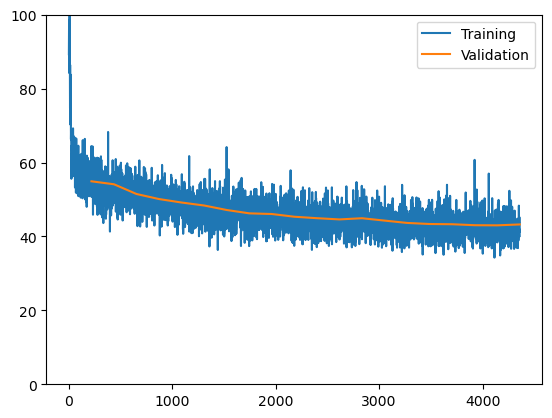

In [28]:
df_train_metrics = pd.DataFrame(metrics['training'], columns=['step', 'score'])
df_valid_metrics = pd.DataFrame(metrics['validation'], columns=['step', 'score'])
plt.plot(df_train_metrics['step'], df_train_metrics['score'], label='Training')
plt.plot(df_valid_metrics['step'], df_valid_metrics['score'], label='Validation')
plt.ylim([0, 100])
plt.legend()
plt.show()

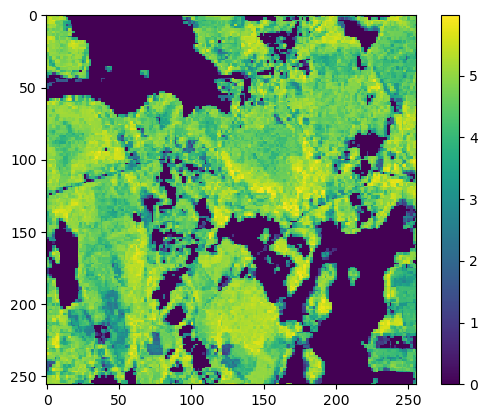

In [29]:
tile_idx = 1000  # arbitrary tile 

sample = dataset[tile_idx]
agbm = sample['label'].squeeze().detach().cpu().numpy()
agbm_log1p = np.log1p(agbm)  # visual comparison is easier with log transform; log1p handles small and 0 values
vmin = agbm_log1p.min()
vmax = agbm_log1p.max()

plt.imshow(agbm_log1p, vmin=vmin, vmax=vmax, interpolation='none')
plt.colorbar()
plt.show()

In [30]:
def predict_agbm(inputs, model):
    pred = model.predict(inputs.unsqueeze(0))
    return pred.detach().squeeze().cpu().numpy()

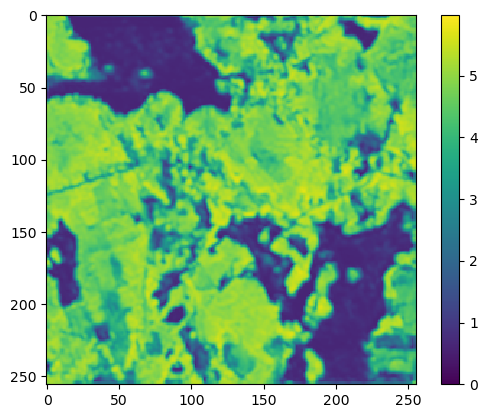

In [31]:
# Show predictions
model.to(device)

tile = sample['image'].to(device)
pred = predict_agbm(tile, model)

plt.imshow(np.log1p(pred), vmin=vmin, vmax=vmax, interpolation='none')
plt.colorbar()
plt.show()

In [35]:
# List of best tiles (per chip) for test data 
tile_file_test = './TILE_LIST_BEST_TEST_MONTHS_v2.csv'
# Test data dir
dir_test = 'data/test'
# Path to save predictions 
dir_save_preds = 'data/preds/test_predictions'

In [36]:
max_chips = None # number of chips to use, None = Use All  

dataset_test = dl.SentinelDataset(tile_file=tile_file_test, # specifies best months of test data 
                                  dir_tiles=dir_test,       # test data dir
                                  dir_target=None,          # No AGBM targets for test data 
                                  max_chips=max_chips,      
                                  transform=transforms,     # same transforms as training
                                  device=loader_device,
                                  metadata=metadata,
                                  path=PATH)

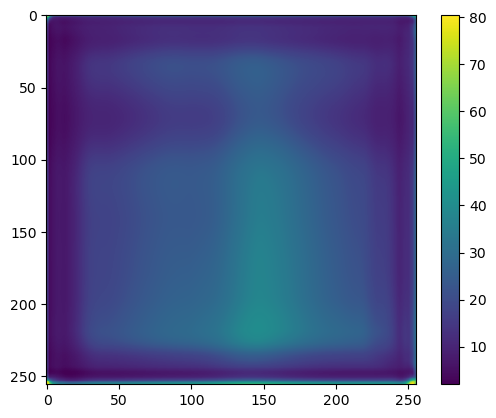

In [39]:
tile_idx = 1000 # arbitrary tile 

chipid = dataset_test.df_tile_list.iloc[tile_idx]['chipid']
inputs = dataset_test[tile_idx]['image'].to(device)
agbm = predict_agbm(inputs, model)

plt.imshow(agbm)
plt.colorbar()
plt.show()

In [ ]:
def save_agbm(agbm_pred, chipid):
    im = Image.fromarray(agbm_pred)
    save_path = os.path.join(dir_save_preds, f'{chipid}_agbm.tif')
    im.save(save_path, format='TIFF', save_all=True)

In [ ]:
model.to(device)

for ix, tile in tqdm(enumerate(dataset_test), total=len(dataset_test)):
    chipid = dataset_test.df_tile_list.iloc[ix]['chipid']
    inputs = tile['image'].to(device)
    agbm = predict_agbm(inputs, model)
    save_agbm(agbm, chipid)

In [ ]:
file_path = os.path.join(dir_save_preds, f'{chipid}_agbm.tif')
with rasterio.open(file_path) as f:
    test_pred = f.read().astype(np.float32)[0]

In [ ]:
plt.imshow(test_pred)
plt.colorbar()
plt.show()